# setup

In [1]:
# !pip install easyimages.

# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

!pip install segmentation_models_pytorch
!pip install roboflow
!pip install pycocotools


Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
^C
ERROR: Operation cancelled by user
  Using cached Cython-3.0.9-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Using cached PyYAML-5.1.tar.gz (274 kB)
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for pyyaml, since package 'wheel' is not installed.
  Running setup.py install for pyyaml ... done


# Lib

In [1]:
import pandas as pd
import numpy as np
import json
import os
import seaborn as sns
from matplotlib.patches import Rectangle
import json
import pandas as pd
import matplotlib.pyplot as plt
# from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from PIL import Image, ImageDraw
import cv2

# from fastai.vision import *
from IPython.core.display import HTML
# HTML("<style>div.output_area pre {white-space: pre;}</style>")
import ipywidgets as widgets
from IPython.display import display

from utils.functions import *
from utils.functions_satellite_image import *

%matplotlib inline

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
# import some common libraries
import numpy as np
import cv2
import random
# from google.colab.patches import cv2_imshow
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, launch
from detectron2.checkpoint import DetectionCheckpointer

import glob
import random
from detectron2.utils.visualizer import Visualizer


import os
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Functions

In [7]:
# import os

# folder = r'data/for_YOLO_v6/sym'

# # Iterate
# i = 1 
# for file in os.listdir(folder):
# 	# Checking if the file is present in the list
# 	# if file in filesRename:
#   oldName = os.path.join(folder, file)
#   n = os.path.splitext(file)[0]

#   b = str(i) + '_new' + '.jpg'
#   newName = os.path.join(folder, b)
#   i = i+1
#   # Rename the file
#   os.rename(oldName, newName)

# res = os.listdir(folder)
# # print(res)

# Read data

In [4]:
dir_read = "data/roof_panel_seg_v6i_coco_segmentation"

In [5]:
json_path = os.path.join(dir_read + '/train', '_annotations.coco.json')
with open(json_path, 'r') as f:
    annot_data_train = json.load(f)

json_path = os.path.join(dir_read + '/valid', '_annotations.coco.json')
with open(json_path, 'r') as f:
    annot_data_valid = json.load(f)

json_path = os.path.join(dir_read + '/test', '_annotations.coco.json')
with open(json_path, 'r') as f:
    annot_data_test = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/roof_panel_seg_v6i_coco_segmentation/train/_annotations.coco.json'

In [11]:
annot_data_train.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [12]:
annot_data_train["info"]

{'year': '2023',
 'version': '6',
 'description': 'Exported from roboflow.ai',
 'contributor': '',
 'url': 'https://public.roboflow.ai/object-detection/undefined',
 'date_created': '2023-05-30T07:36:03+00:00'}

In [13]:
annot_data_train['licenses']

[{'id': 1,
  'url': 'https://creativecommons.org/licenses/by/4.0/',
  'name': 'CC BY 4.0'}]

In [14]:
annot_data_train["categories"]

[{'id': 0, 'name': 'roof-panel', 'supercategory': 'none'},
 {'id': 1, 'name': 'background', 'supercategory': 'roof-panel'},
 {'id': 2, 'name': 'panel', 'supercategory': 'roof-panel'},
 {'id': 3, 'name': 'roof', 'supercategory': 'roof-panel'}]

In [15]:
annot_data_train["images"][2]["file_name"]

'map_39-089541053633006_-94-57887637152714_39-09067772224719_-94-57673328652425_0_500_png_jpg.rf.463052552493126ab303cdbd8adada0d.jpg'

In [16]:
df_train = pd.DataFrame(annot_data_train['annotations'])
df_valid = pd.DataFrame(annot_data_valid['annotations'])
df_test = pd.DataFrame(annot_data_test['annotations'])

print("df_train shape:", df_train.shape)
print("df_valid shape:", df_valid.shape)
print("df_test shape:", df_test.shape)

df_train["category_name"] = df_train["category_id"].apply(lambda x : replace_name_of_categori(x))
df_valid["category_name"] = df_train["category_id"].apply(lambda x : replace_name_of_categori(x))
df_test["category_name"] = df_train["category_id"].apply(lambda x : replace_name_of_categori(x))

df_train["image_name"] = None
df_train["height"] = None
df_train["width"] = None


df_valid["image_name"] = None
df_valid["height"] = None
df_valid["width"] = None


df_test["image_name"] = None
df_test["height"] = None
df_test["width"] = None

for i in range(0,len(annot_data_train["images"])):
  img_id = annot_data_train["images"][i]["id"]
  image_name = annot_data_train["images"][i]["file_name"]
  h = annot_data_train["images"][i]["height"]
  w = annot_data_train["images"][i]["width"]
  x = df_train[df_train["image_id"] == img_id].index
  df_train.iloc[x,df_train.columns.get_loc("image_name")] = image_name
  df_train.iloc[x,df_train.columns.get_loc("height")] = h
  df_train.iloc[x,df_train.columns.get_loc("width")] = w



for i in range(0,len(annot_data_valid["images"])):
  img_id = annot_data_valid["images"][i]["id"]
  image_name = annot_data_valid["images"][i]["file_name"]
  h = annot_data_valid["images"][i]["height"]
  w = annot_data_valid["images"][i]["width"]
  x = df_valid[df_valid["image_id"] == img_id].index
  df_valid.iloc[x,df_valid.columns.get_loc("image_name")] = image_name
  df_valid.iloc[x,df_valid.columns.get_loc("height")] = h
  df_valid.iloc[x,df_valid.columns.get_loc("width")] = w


for i in range(0,len(annot_data_test["images"])):
  img_id = annot_data_test["images"][i]["id"]
  image_name = annot_data_test["images"][i]["file_name"]
  h = annot_data_test["images"][i]["height"]
  w = annot_data_test["images"][i]["width"]
  x = df_test[df_test["image_id"] == img_id].index
  df_test.iloc[x,df_test.columns.get_loc("image_name")] = image_name
  df_test.iloc[x,df_test.columns.get_loc("height")] = h
  df_test.iloc[x,df_test.columns.get_loc("width")] = w



df_train.sample(10)

df_train shape: (4608, 7)
df_valid shape: (1161, 7)
df_test shape: (706, 7)


,id,image_id,category_id,bbox,area,segmentation,iscrowd,category_name,image_name,height,width
4022,4022,541,2,"[329, 260, 152.793, 125.793]",19220.280,"[[393.514, 357.517, 407.928, 353.103, 422.342,...",0,roof,Screenshot-from-2023-05-18-23-03-47_png_jpg.rf...,640,640
346,346,52,3,"[100, 336, 161.054, 189.323]",30491.246,"[[99.987, 525.506, 261.041, 525.506, 261.041, ...",0,None,Screenshot-from-2023-05-18-23-11-30_png_jpg.rf...,640,640
322,322,48,3,"[38, 457, 338.824, 179.884]",60949.065,"[[352.198, 633.526, 349.721, 630.289, 373.498,...",0,None,Screenshot-from-2023-05-18-21-55-47_png_jpg.rf...,640,640
2320,2320,320,3,"[405, 478, 113.062, 115.823]",13095.147,"[[505.353, 560.343, 515.289, 551.645, 518.03, ...",0,None,Screenshot-from-2023-05-18-21-57-48_png_jpg.rf...,640,640
1108,1108,144,2,"[242, 81, 31.39, 20.915]",656.515,"[[264.196, 80.871, 242.398, 82.963, 243.27, 10...",0,roof,Screenshot-from-2023-05-18-23-04-08_png_jpg.rf...,640,640
3806,3806,508,3,"[340, 339, 71.68, 100.48]",7202.406,"[[409.6, 343.68, 369.28, 339.2, 343.68, 341.76...",0,None,map_38-714445520676826_-90-15762869485016_38-7...,640,640
415,415,62,2,"[281, 132, 210.591, 506.466]",106657.348,"[[487.815, 158.797, 456.555, 132.331, 445.861,...",0,roof,Screenshot-from-2023-05-18-22-34-04_png_jpg.rf...,640,640
4388,4388,593,2,"[364, 143, 16.842, 10.575]",178.100,"[[367.368, 143.448, 364.211, 153.103, 381.053,...",0,roof,Screenshot-from-2023-05-18-23-11-23_png_jpg.rf...,640,640
3704,3704,490,3,"[41, 335, 224, 60.8]",13619.200,"[[184.96, 381.44, 229.76, 386.56, 234.88, 380....",0,None,map_39-26435144703396_-103-67724421636495_39-2...,640,640
4456,4456,598,3,"[366, 4, 93.44, 78.72]",7355.597,"[[459.52, 60.8, 446.72, 53.12, 437.76, 37.76, ...",0,None,map_39-262416747900346_-103-69051596333789_39-...,640,640


# Plot image with box and polygons of each segmentation

In [17]:
import glob
dir_read = "/content/drive/MyDrive/Proactiveware/data/roof_panel_seg_v6i_png_mask_semantic"
train_images =  glob.glob(dir_read + "/train/*jpg")
valid_images =  glob.glob(dir_read + "/valid/*jpg")
test_images =  glob.glob(dir_read + "/test/*jpg")
print("no_train_image", len(train_images))
print("no_masked_train" , df_train.groupby("image_id").count()["id"].shape[0])
print("no_valid",len(valid_images))
print("no_masked_valid" , df_valid.groupby("image_id").count()["id"].shape[0])
print("no_test", len(test_images))
print( "no_masked_test" , df_test.groupby("image_id").count()["id"].shape[0])

no_train_image 628
no_masked_train 602
no_valid 178
no_masked_valid 171
no_test 92
no_masked_test 90


In [ ]:
  
# data =df_test
# image_id_list = data["image_id"].unique().tolist()
# name = "train"
# dir_ = "/content/drive/MyDrive/Proactiveware/data/for_coco_segmentation/test/"

def creat_mask(data, name, dir_):
  """creating mask for panel in blue and for roof in red"""
  image_id_list = data["image_id"].unique().tolist()

  for k in image_id_list:
    print(k)

    df = data[data["image_id"] == k]
    df.sort_values("area", inplace = True, ascending = False)

    file_name = df.iloc[0]["image_name"]

    image = Image.open(dir_ + file_name)
    image_1 = image.copy()
    # Image.open(dir_ + file_name)
    im = cv2.imread(dir_ + file_name)
    h, w, c = im.shape


    draw = ImageDraw.Draw(image)
    rectangle = [(0, 0), (w, h)]
    draw.rectangle(rectangle , outline="black", fill = "black")


    for i, row in df.iterrows():
        bbox = row['bbox']  

        segmentation = row["segmentation"][0]
        if row["category_id"] == 1:
          color_of_category = 'blue'

        if row["category_id"] == 2:
          color_of_category = "red"

        pair_of_tuples = [(segmentation[i], segmentation[i+1]) for i in range(0, len(segmentation), 2)]
        draw.polygon(pair_of_tuples, outline='red', fill = color_of_category )

    name_2 = name + "_mask"
    image.save(f'data/for_semantic_seg_mask_v6/{name_2}/{name}_{k}.jpg')
    image_1.save(f'data/for_semantic_seg_mask_v6/{name}/{name}_{k}.jpg')





In [ ]:
data =df_train
name = "train"
dir_ = dir_read  + "/train/"
creat_mask(data, name, dir_)


data =df_valid
name = "valid"
dir_ = dir_read + "/valid/"
creat_mask(data, name, dir_ )


data =df_test
name = "test"
dir_ = dir_read + "/test/"
creat_mask(data,name,dir_)

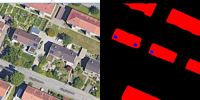

In [ ]:
i = 5
dir_ = "/content/drive/MyDrive/Proactiveware/data/for_semantic_seg_mask_v6/test/"
dir_mask = "/content/drive/MyDrive/Proactiveware/data/for_semantic_seg_mask_v6/test_mask/"
file_name = f"test_{i}.jpg"


In [ ]:
import random

n = 20  # Number of random integers to select
start = 0  # Start of the range
end = df_test.groupby("image_id").count()["id"].shape[0]  # End of the range

random_numbers = []  # List to store the random numbers

for _ in range(n):
    random_number = random.randint(start, end)
    random_numbers.append(random_number)

# print(random_numbers)

for i in random_numbers:
  dir_ = "data/for_semantic_seg_mask_2/train/"
  dir_mask = "data/for_semantic_seg_mask_2/train_mask/"
  file_name = f"train_{i}.jpg"
  image = Image.open(dir_ + file_name).resize((200, 200))
  image_mask = Image.open(dir_mask + file_name).resize((200, 200))

  Image.fromarray(np.hstack((np.array(image),np.array(image_mask)))).show()




Output hidden; open in https://colab.research.google.com to view.

In [ ]:
x ="data/for_semantic_seg_mask/test/Screenshot-from-2023-05-18-22-10-54_png_jpg.rf.f32cd8b51bf0d634790e8c100235610a_mask.png"

im = cv2.imread(x)
np.unique(im)

array([None], dtype=object)

# create DataFrame(content information of images) for adderessing images

In [22]:
dir_read = "data/roof_panel_seg_v6i_png_mask_semantic"

## train set

In [19]:
train_ =  glob.glob(dir_read + "/train/*png")
train_mask =  glob.glob(dir_read + "/train/*_mask.png")
print("no_train_image", len(train_images))
print("no_masked_train" , df_train.groupby("image_id").count()["id"].shape[0])

print("no_mask",len(train_mask))
train_mask[0]

image = cv2.imread(image_name)


list_of_image_ad = []
for i in train_mask:
  tm = i
  t = i.replace("_mask.png", ".jpg")
  image = cv2.imread(i)
  h, w, c = image.shape

  list_of_image_ad.append([t, tm,  h, w, c ] )


print(list_of_image_ad[0][0])
print(list_of_image_ad[0][1])

df_train_dir = pd.DataFrame(list_of_image_ad, columns = ["image", "mask", "h", "w", "c"])

df_train_dir = df_train_dir[df_train_dir["h"] == 640]
df_train_dir.to_csv(dir_read + "/train_semantic_seg_mask.csv")

df_train_dir.head(2)

no_train_image 628
no_masked_train 602
no_mask 623
/content/drive/MyDrive/Proactiveware/data/roof_panel_seg_v6i_png_mask_semantic/train/Screenshot-from-2023-05-18-22-23-07_png_jpg.rf.582d7853de44a5609f1ab326679e6b4f.jpg
/content/drive/MyDrive/Proactiveware/data/roof_panel_seg_v6i_png_mask_semantic/train/Screenshot-from-2023-05-18-22-23-07_png_jpg.rf.582d7853de44a5609f1ab326679e6b4f_mask.png


,image,mask,h,w,c
0,/content/drive/MyDrive/Proactiveware/data/roof...,/content/drive/MyDrive/Proactiveware/data/roof...,640,640,3
1,/content/drive/MyDrive/Proactiveware/data/roof...,/content/drive/MyDrive/Proactiveware/data/roof...,640,640,3


In [ ]:
df_train_dir[df_train_dir["h"] < 640].shape

(0, 5)

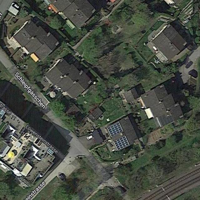

In [ ]:
i = 0

dir_ = df_train_dir.iloc[i]["image"]
dir_mask = df_train_dir.iloc[i]["mask"]

image = Image.open(dir_).resize((200, 200))
image_mask = Image.open(dir_mask).resize((200, 200))

Image.fromarray(np.array(image)).show()

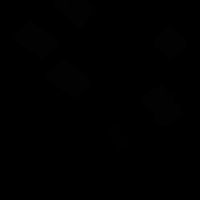

In [ ]:
Image.fromarray(np.array(image_mask)).show()

## valid sest

In [23]:
valid_ =  glob.glob(dir_read + "/valid/*")
valid_mask =  glob.glob(dir_read + "/valid/*_mask.png")

print("no_valid_image", len(valid_))
print("no_masked_valid" , df_valid.groupby("image_id").count()["id"].shape[0])

print("no_mask",len(valid_mask))
print(valid_mask[0])


list_of_image_ad = []
for i in valid_mask:
  tm = i
  t = i.replace("_mask.png", ".jpg")

  image = cv2.imread(tm)
  h, w, c = image.shape

  image = cv2.imread(t)
  ht, wt, ct = image.shape

  list_of_image_ad.append([t, tm,  h, w, c , ht, wt, ct] )


print(list_of_image_ad[0][0])
print(list_of_image_ad[0][1])

df_valid_dir = pd.DataFrame(list_of_image_ad, columns = ["image", "mask", "hm", "wm", "cm", "h", "w", "c"])
df_valid_dir = df_valid_dir[ df_valid_dir["hm"] == 640]
df_valid_dir.to_csv(dir_read + "/valid_semantic_seg_mask.csv")

df_valid_dir.head(2)

no_valid_image 357
no_masked_valid 171
no_mask 178
/content/drive/MyDrive/Proactiveware/data/roof_panel_seg_v6i_png_mask_semantic/valid/map_39-091041292276365_-94-58593799817265_39-09181987487335_-94-58483829247655_0_500_png_jpg.rf.19e7785fef2b2a672bd73091cfcfceb8_mask.png
/content/drive/MyDrive/Proactiveware/data/roof_panel_seg_v6i_png_mask_semantic/valid/map_39-091041292276365_-94-58593799817265_39-09181987487335_-94-58483829247655_0_500_png_jpg.rf.19e7785fef2b2a672bd73091cfcfceb8.jpg
/content/drive/MyDrive/Proactiveware/data/roof_panel_seg_v6i_png_mask_semantic/valid/map_39-091041292276365_-94-58593799817265_39-09181987487335_-94-58483829247655_0_500_png_jpg.rf.19e7785fef2b2a672bd73091cfcfceb8_mask.png


,image,mask,hm,wm,cm,h,w,c
0,/content/drive/MyDrive/Proactiveware/data/roof...,/content/drive/MyDrive/Proactiveware/data/roof...,640,640,3,640,640,3
1,/content/drive/MyDrive/Proactiveware/data/roof...,/content/drive/MyDrive/Proactiveware/data/roof...,640,640,3,640,640,3


In [24]:
df_valid_dir[df_valid_dir["h"]< 640].shape

(0, 8)

## test set

In [25]:
test_ =  glob.glob(dir_read + "/test/*")
test_mask =  glob.glob(dir_read + "/test/*_mask.png")

print("no_test_image", len(test_))
print("no_masked_test" , df_test.groupby("image_id").count()["id"].shape[0])

print("no_mask",len(test_mask))
print(test_mask[0])


list_of_image_ad = []
for i in test_mask:
  tm = i
  t = i.replace("_mask.png", ".jpg")
  image = cv2.imread(i)
  h, w, c = image.shape

  list_of_image_ad.append([t, tm,  h, w, c ] )


print(list_of_image_ad[0][0])
print(list_of_image_ad[0][1])

df_test_dir = pd.DataFrame(list_of_image_ad, columns = ["image", "mask", "h", "w", "c"])
df_test_dir = df_test_dir[df_test_dir["h"]==640]
df_test_dir.to_csv(dir_read + "/test_semantic_seg_mask.csv")

df_test_dir.head(2)

no_test_image 185
no_masked_test 90
no_mask 92
/content/drive/MyDrive/Proactiveware/data/roof_panel_seg_v6i_png_mask_semantic/test/map_38-78691350984219_-90-22341033672042_38-78794841424135_-90-22161593888946_0_500_png_jpg.rf.a4d3a1415015cc673cac8d4e62affb58_mask.png
/content/drive/MyDrive/Proactiveware/data/roof_panel_seg_v6i_png_mask_semantic/test/map_38-78691350984219_-90-22341033672042_38-78794841424135_-90-22161593888946_0_500_png_jpg.rf.a4d3a1415015cc673cac8d4e62affb58.jpg
/content/drive/MyDrive/Proactiveware/data/roof_panel_seg_v6i_png_mask_semantic/test/map_38-78691350984219_-90-22341033672042_38-78794841424135_-90-22161593888946_0_500_png_jpg.rf.a4d3a1415015cc673cac8d4e62affb58_mask.png


,image,mask,h,w,c
0,/content/drive/MyDrive/Proactiveware/data/roof...,/content/drive/MyDrive/Proactiveware/data/roof...,640,640,3
1,/content/drive/MyDrive/Proactiveware/data/roof...,/content/drive/MyDrive/Proactiveware/data/roof...,640,640,3


In [26]:
df_test_dir[df_test_dir["h"]<640].shape

(0, 5)